In [1]:
import torch

# import some helper functions from chrislib (will be installed by the intrinsic repo)
from chrislib.general import show, view, uninvert, match_scale
from chrislib.data_util import load_image

# import model loading and running the pipeline
from intrinsic.pipeline import run_pipeline
from intrinsic.model_util import load_models

/home/vishal/anaconda3/envs/iidecomp/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
intrinsic_model = load_models('paper_weights')

Using cache found in /home/vishal/.cache/torch/hub/facebookresearch_WSL-Images_main
Using cache found in /home/vishal/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


In [4]:
import numpy as np

In [14]:
inp = load_image('/home/vishal/Volume_E/Active/Gap_year/research/3d_manipulation/codes/intrinsic_image_decomposition/test_images/3.jpeg')[:, :, :3]
msk = np.stack((load_image('/home/vishal/Volume_E/Active/Gap_year/research/3d_manipulation/codes/intrinsic_image_decomposition/results/fastsam/3_seg.png'),) * 3, axis=-1)[:, :, :3] # load_image('/home/vishal/Volume_E/Active/Gap_year/research/3d_manipulation/codes/intrinsic_image_decomposition/results/fastsam/3_seg.png')[:, :, :3]
msk_whole = np.ones((256, 256, 3))
tex = load_image('/home/vishal/Volume_E/Active/Gap_year/research/3d_manipulation/codes/intrinsic_image_decomposition/recoloring_textures/yellow_plain_big.jpg')[:, :, :3] ** 2.2

In [13]:
msk.shape

(256, 256, 3)

In [15]:
results = run_pipeline(
    intrinsic_model,
    inp,
    resize_conf=None,
    maintain_size=True
)

alb = results['albedo']
image = results['image']
inv_shd = results['inv_shading']

shd = uninvert(inv_shd)[:, :, None]

In [16]:
def perform_recolor(msk, alb, shd, shd_power=1.0, recolor=None):
    # this function will perform the illumination-aware recoloring, or apply a shading curve
    # msk - numpy array (HxWx1) denoting the region to perform the edit
    # alb - linear albedo of the image
    # shd - linear shading of the image
    # shd_power - exponent to apply to the shading (<1 for more diffuse, >1 for more specular)
    # recolor - a texture to apply to the edited region, no recoloring is performed if set to None

    if recolor is None:
        our_new_alb = alb
    else:
        # we match the scale of the texture to the albedo in the edited region to
        # ensure the appearance of the region is maintained, but this can be altered
        recolor = match_scale(recolor, alb, msk.astype(bool))
        our_new_alb = ((1.0 - msk) * alb) + (msk * recolor)

    # apply exponentiation to the shading of the region and composite
    masked_shd = msk * (shd ** shd_power)
    new_shd = ((1.0 - msk) * shd) + masked_shd

    # combine edited albedo and shading, gamma correct and clip
    recolored = (our_new_alb * new_shd) ** (1/2.2)

    return recolored.clip(0, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


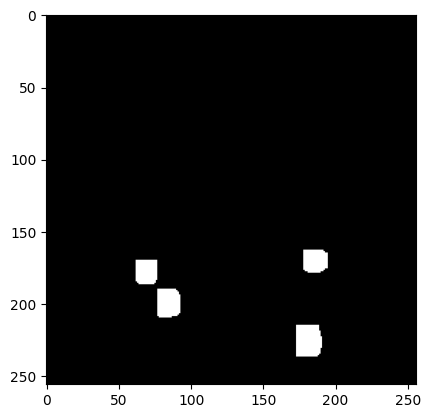

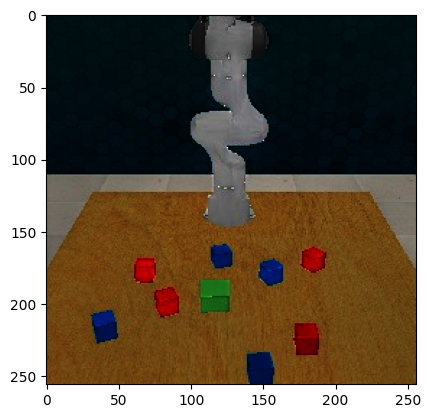

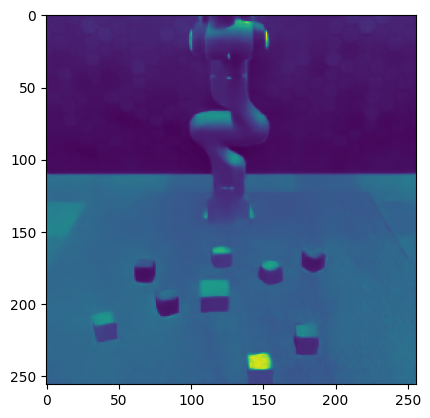

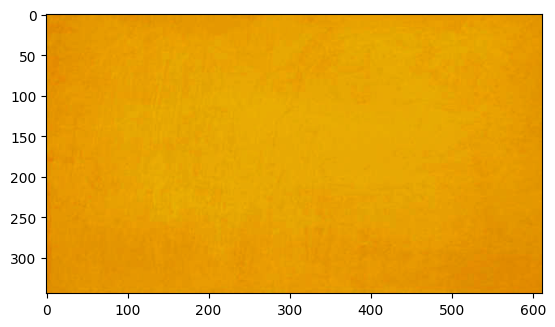

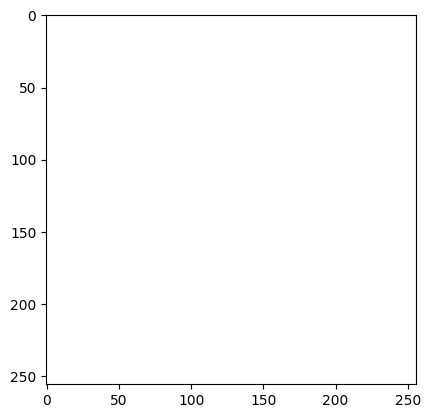

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(0)
plt.imshow(msk)
plt.figure(1)
plt.imshow(alb)
plt.figure(2)
plt.imshow(shd)
plt.figure(3)
plt.imshow(tex)
plt.figure(4)
plt.imshow(msk_whole)

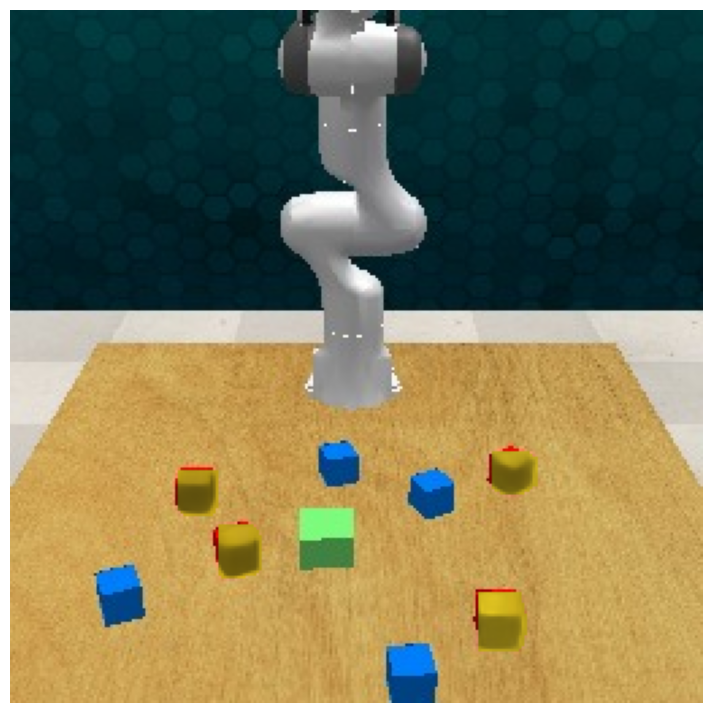

In [22]:
# NOTE: setting the shading exponent to >1 will make the shading appear more specular,
# but small errors in the shading (albedo leakage) will be amplified in some cases
recolored_img = perform_recolor(msk, alb, shd, 1.0, recolor=tex[:256, :256, :])
show(recolored_img)

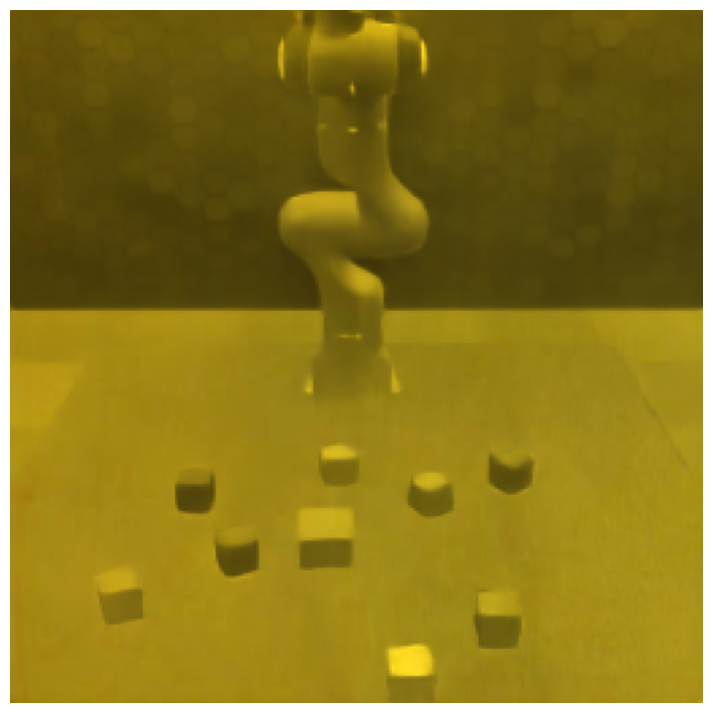

In [24]:
'''
Single color recoloring
'''
whole_recolored_img = perform_recolor(msk_whole, alb, shd, 1.0, recolor=tex[:256, :256, :])
show(whole_recolored_img)

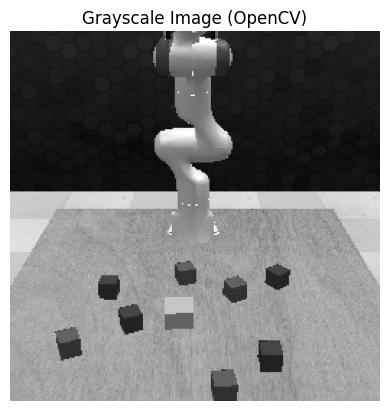

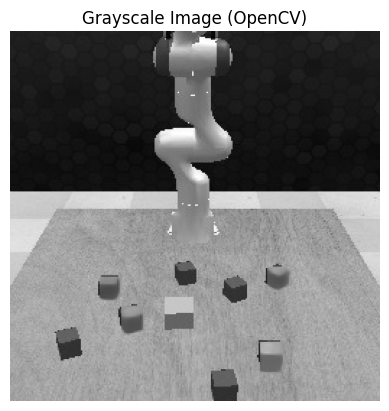

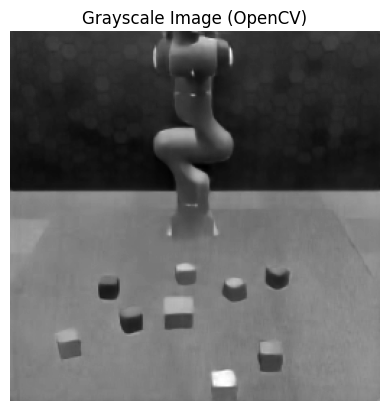

In [25]:
import cv2

# Convert the image to grayscale using OpenCV
gray_image_cv2 = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

gray_recolored_img_cv2 = cv2.cvtColor((recolored_img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

gray_whole_recolored_img_cv2 = cv2.cvtColor((whole_recolored_img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

# Display the grayscale image
plt.figure(6)
plt.imshow(gray_image_cv2, cmap='gray')
plt.title('Grayscale Image (OpenCV)')
plt.axis('off')
plt.show()

# Display the grayscale image
plt.figure(7)
plt.imshow(gray_recolored_img_cv2, cmap='gray')
plt.title('Grayscale Image (OpenCV)')
plt.axis('off')
plt.show()

# Display the grayscale image
plt.figure(8)
plt.imshow(gray_whole_recolored_img_cv2, cmap='gray')
plt.title('Grayscale Image (OpenCV)')
plt.axis('off')
plt.show()

In [16]:
import numpy as np
# np.hstack([load_image().resize((256, 256, 1)).repeat(2, axis=1)])
np.stack((load_image('/home/vishal/Volume_E/Active/Gap_year/research/3d_manipulation/codes/intrinsic_image_decomposition/results/fastsam/3_seg.png'),) * 3, axis=-1).shape

(256, 256, 3)

In [30]:
load_image('/home/vishal/Volume_E/Active/Gap_year/research/3d_manipulation/codes/intrinsic_image_decomposition/recoloring_textures/japan.png').shape

(183, 275)

In [32]:
from PIL import Image
img = Image.open('/home/vishal/Volume_E/Active/Gap_year/research/3d_manipulation/codes/intrinsic_image_decomposition/recoloring_textures/japan.png')

In [33]:
imgg = img.convert('RGB')